In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import random
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import pandas_datareader as pdr

In [59]:
def tree_to_table(tree, name_str):
    n_gen = len(tree)
    n_chrom = len(tree[0])
    name = []
    gen = []
    chrom = []
    ret = []
    vol = []
    sr = []
    res = []
    for i in range(n_gen):
        for j in range(n_chrom):
            name.append(name_str)
            gen.append(i)
            chrom.append(j)
            ret.append(tree[i][j].get_expected_return())
            vol.append(tree[i][j].get_volatility())
            sr.append(tree[i][j].get_sharpe_ratio())
    d = {'name': name, 'generation': gen, 'chromosome': chrom, 'return': ret, 'volatility': vol, 'sharpe_ratio': sr}
    df = pd.DataFrame(data=d)
    return df

In [60]:
class Portfolio:
    def __init__(self, returns_df, corr_matrix, risk_free):
        self.returns = returns_df
        self.corr = corr_matrix
        self.description = self.returns.describe()
        self.n_assets = self.returns.shape[1]
        self.risk_free = risk_free
        self.initialize_weights()
        self.set_expected_return()
        self.set_volatility()
        self.set_sharpe_ratio()
        return None
    def initialize_weights(self):
        self.weights = np.random.rand(self.n_assets)
        self.weights = (self.weights/self.weights.sum())
        return None
    def set_weights(self, weights):
        self.weights = (weights/weights.sum())
        self.set_discrete_weights = self.weights
        return None
    def set_expected_return(self):
        weighted = self.weights*self.description.loc['mean']
        self.expected_return = weighted.sum().round(2)
        return None
    def set_volatility(self):
        std = self.description.loc['std'].values
        m1 = (self.weights*std).reshape(self.n_assets,1)
        m2 = m1.reshape(1,self.n_assets)
        self.volatility = math.sqrt((m1*self.corr*m2).sum())
        return None
    def set_sharpe_ratio(self):
        self.sharpe_ratio = (self.expected_return-self.risk_free)/self.volatility
        return None
    def get_weights(self):
        return self.weights
    def get_expected_return(self):
        return self.expected_return
    def get_volatility(self):
        return self.volatility
    def get_sharpe_ratio(self):
        return self.sharpe_ratio

In [61]:
class Genetic_algorithm:
    def __init__(self, returns_df, corr_matrix, risk_free, size):
        self.returns = returns_df
        self.corr = corr_matrix
        self.risk_free = risk_free
        self.size = size
        return None
    def run(self, iterations, variable):
        self.initialize()
        for i in range(iterations):
            self.set_fitness(variable)
            self.select_fittest()
            self.crossover()
            self.mutation()
            self.pass_generation(variable)
        return None
    

    def initialize(self):
        self.population = []
        self.offspring = []
        self.population_best = []
        self.population_fitness = []
        self.population_mean  = []
        self.tree = list()
        for i in range(self.size):
            self.population.append(Portfolio(self.returns, self.corr, self.risk_free))
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        return None
    
    
    def set_fitness(self, variable):
        if(variable == 'volatility'):
            max_volatility = self.population_df[variable].max()
            self.population_df.sort_values(by=variable, inplace=True, ascending=True)
            self.population_df['fitness'] = max_volatility - self.population_df[variable] + 1
            self.population_df['fitness'] = self.population_df['fitness']/self.population_df['fitness'].sum()
        else:
            self.population_df.sort_values(by=variable, inplace=True, ascending=False)
            self.population_df['fitness'] = self.population_df[variable]/self.population_df[variable].sum()
        self.population_df['selection_prob'] = self.population_df['fitness']
        for i in range(1, len(self.population_df['selection_prob'])):
            self.population_df['selection_prob'].iloc[i] = self.population_df['selection_prob'].iloc[i-1] + self.population_df['selection_prob'].iloc[i]
        return self.population_df
    
    
    def select_fittest(self, rand = True):
        third = int(self.size/3)
        idx = self.population_df.head(third).index.values
        if(rand == True):
            for i in idx:
                self.offspring.append(self.population[i])
                p = Portfolio(self.returns, self.corr, self.risk_free)
                self.offspring.append(p)
        else:
            for i in idx:
                self.offspring.append(self.population[i])
        return None
    def crossover(self):
        rest = self.size - len(self.offspring)
        for i in range(rest):
            idx_parent1 = self.select_parent()
            idx_parent2 = self.select_parent()
            alpha = random.random()
            w3 = alpha*self.population[idx_parent1].get_weights() + (1-alpha)*self.population[idx_parent2].get_weights()
            p = Portfolio(self.returns, self.corr, self.risk_free)
            p.set_weights(w3)
            self.offspring.append(p)
        return None
    def mutation(self):
        n_assets = len(self.population[0].get_weights())
        for child in self.offspring:
            idx1 = random.randrange(0,n_assets)
            idx2 = random.randrange(0,n_assets)
            w = child.get_weights()
            minimo = min(w[idx1],w[idx2])
            rand = random.uniform(0,minimo)
            w[idx1] += rand
            w[idx2] -= rand
            child.set_weights(w)
        return None
    def pass_generation(self, variable):
        self.population = self.offspring
        self.offspring = []
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        best = self.population[0]
        mean_fit = self.population_df[variable].mean()
        if(variable == 'volatility'):
            max_fit = self.population_df.sort_values(by=variable, ascending=True).head(1)[variable].iloc[0]
        else:
            max_fit = self.population_df.sort_values(by=variable, ascending=False).head(1)[variable].iloc[0]
        self.population_best.append(best)
        self.population_fitness.append(max_fit)
        self.population_mean.append(mean_fit)
        return None
    def select_parent(self):
        roulette = random.random()
        i = 0
        while roulette > self.population_df['selection_prob'].iloc[i]: 
            i += 1
        if(i > 0):
            i = i - 1
        return self.population_df.iloc[i,:].name
    def to_table(self, array):
        exp_returns = [s.get_expected_return() for s in array]
        volatilities = [s.get_volatility() for s in array]
        sharpe_ratios = [s.get_sharpe_ratio() for s in array]
        d = {'return': exp_returns, 'volatility': volatilities, 'sharpe_ratio' : sharpe_ratios}
        df = pd.DataFrame(data=d) 
        return df
    def get_samples(self):
        return self.samples
    def get_population(self,variable):
        self.population_df.sort_values(by=variable, inplace=True, ascending=False)
        idx = self.population_df.head(1).index.values[0]
        return self.population[idx]
    def get_tree(self, variable):
        return self.tree
    def get_analysis(self):
        d = {'best_fitness':self.population_fitness,'fitness_mean':self.population_mean}
        output = pd.DataFrame(data=d) 
        return output
    
    

In [616]:
def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

ticker = ['VDC', 'VFH', 'VHT', 'VDE','VGT']
all_data = get(ticker, datetime.datetime(2019, 1, 1), datetime.datetime(2020, 1, 1))

df = all_data['Close'].to_frame().reset_index()
df=(df.pivot(index='Date', columns='Ticker'))

In [617]:
df=pd.DataFrame(df)
df

Close                                              
Ticker             VDC        VDE        VFH         VGT         VHT
Date                                                                
2019-01-02  130.679993  78.820000  59.810001  166.929993  158.460007
2019-01-03  129.740005  78.080002  58.779999  158.679993  154.880005
2019-01-04  132.529999  80.949997  60.700001  165.580002  159.809998
2019-01-07  132.410004  82.269997  60.840000  167.429993  161.229996
2019-01-08  133.669998  82.970001  60.930000  169.039993  162.960007
...                ...        ...        ...         ...         ...
2019-12-24  161.039993  81.730003  76.089996  243.850006  193.070007
2019-12-26  161.250000  81.669998  76.500000  245.729996  192.589996
2019-12-27  161.919998  81.209999  76.309998  245.639999  192.600006
2019-12-30  161.139999  80.980003  76.110001  244.179993  191.199997
2019-12-31  161.199997  81.489998  76.279999  244.850006  191.740005

[252 rows x 5 columns]

In [618]:
monthly_retunrs = df.resample('M').ffill().pct_change()*100


In [619]:
stock_names = ['VDC','VDE','VFH','VGT','VHT']

In [620]:
monthly_retunrs

Close                                         
Ticker           VDC        VDE       VFH       VGT       VHT
Date                                                         
2019-01-31       NaN        NaN       NaN       NaN       NaN
2019-02-28  2.031813   2.170888  3.110091  7.326819  1.639918
2019-03-31  2.905539   1.556636 -3.628491  3.759828 -0.254454
2019-04-30  2.534256  -0.190197  8.552830  6.369934 -2.695961
2019-05-31 -4.184294 -11.702727 -7.008273 -8.879620 -2.675329
2019-06-30  4.275894   7.934493  5.924790  8.449034  6.489535
2019-07-31  2.359512  -2.411192  2.738733  3.537392 -1.305050
2019-08-31  1.595845  -8.713997 -5.162205 -2.193730 -1.176679
2019-09-30  1.202328   3.010297  4.104703  0.931825 -1.161215
2019-10-31 -0.459888  -2.627526  2.042858  3.753188  4.782923
2019-11-30  1.456625   1.079373  4.941899  5.593809  6.129769
2019-12-31  1.954333   6.120585  1.760939  3.684104  2.826194

(5.5, -0.5)

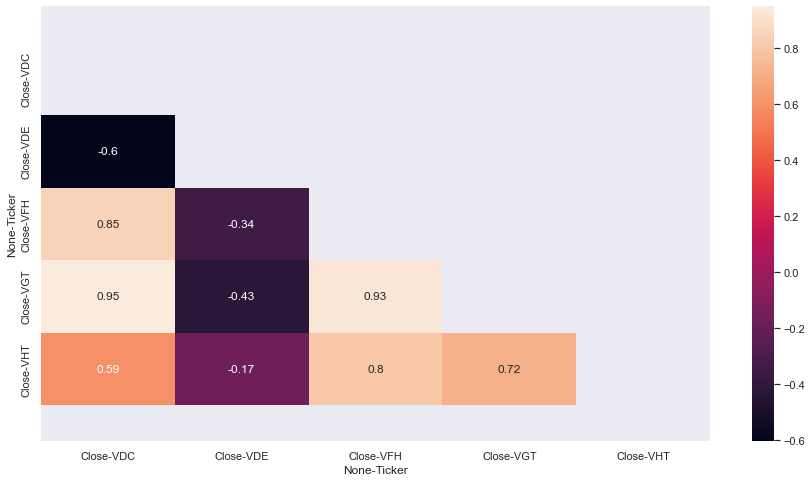

In [621]:
corr = df.corr()
corr_matrix = corr.values
sns.set()
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(data=corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [622]:
population_size = 100
n_generations = 100
risk_free=2.14
GA = Genetic_algorithm(monthly_retunrs, corr_matrix, risk_free, population_size)

In [623]:
variable = 'return'
GA.run(n_generations,variable)
tree1 = GA.get_tree(variable)
analysis1 = GA.get_analysis()
variable = 'volatility'
GA.run(n_generations,variable)
tree2 = GA.get_tree(variable)
analysis2 = GA.get_analysis()
variable = 'sharpe_ratio'
GA.run(n_generations,variable)
tree3 = GA.get_tree(variable)
analysis3 = GA.get_analysis()

In [624]:
result1_df = tree_to_table(tree1, 'tree_1')
result2_df = tree_to_table(tree2, 'tree_2')
result3_df = tree_to_table(tree3, 'tree_3')
results_df = pd.concat([result1_df, result2_df, result3_df])

In [625]:
results_df.sort_values(by = ['return','volatility'], inplace=True, ascending=[False,True])
b1 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
9037,tree_3,90,37,2.54,4.465047,0.089585
9100,tree_3,91,0,2.54,4.465047,0.089585
9200,tree_3,92,0,2.54,4.465047,0.089585
9300,tree_3,93,0,2.54,4.465047,0.089585
9400,tree_3,94,0,2.54,4.465047,0.089585
...,...,...,...,...,...,...
7377,tree_2,73,77,0.26,3.758060,-0.500258
1683,tree_1,16,83,0.25,3.703888,-0.510275
425,tree_3,4,25,0.24,3.607254,-0.526716
9201,tree_1,92,1,0.21,3.869964,-0.498713


In [626]:
results_df.sort_values(by = ['volatility','return'], inplace=True, ascending=[True,False])
b2 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
178,tree_1,1,78,1.05,1.596554,-0.682720
2213,tree_1,22,13,1.07,1.636996,-0.653636
6855,tree_2,68,55,1.08,1.676440,-0.632292
6900,tree_2,69,0,1.08,1.676440,-0.632292
7000,tree_2,70,0,1.08,1.676440,-0.632292
...,...,...,...,...,...,...
9726,tree_1,97,26,2.19,4.530863,0.011035
9828,tree_1,98,28,2.19,4.530863,0.011035
9928,tree_1,99,28,2.19,4.530863,0.011035
10028,tree_1,100,28,2.19,4.530863,0.011035


In [627]:
results_df.sort_values(by='sharpe_ratio', inplace=True, ascending=False)
b3 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
9800,tree_3,98,0,2.54,4.465047,0.089585
9700,tree_3,97,0,2.54,4.465047,0.089585
9037,tree_3,90,37,2.54,4.465047,0.089585
9100,tree_3,91,0,2.54,4.465047,0.089585
9200,tree_3,92,0,2.54,4.465047,0.089585
...,...,...,...,...,...,...
6600,tree_2,66,0,0.86,1.734298,-0.738051
6700,tree_2,67,0,0.86,1.734298,-0.738051
6800,tree_2,68,0,0.86,1.734298,-0.738051
6902,tree_2,69,2,0.86,1.734298,-0.738051


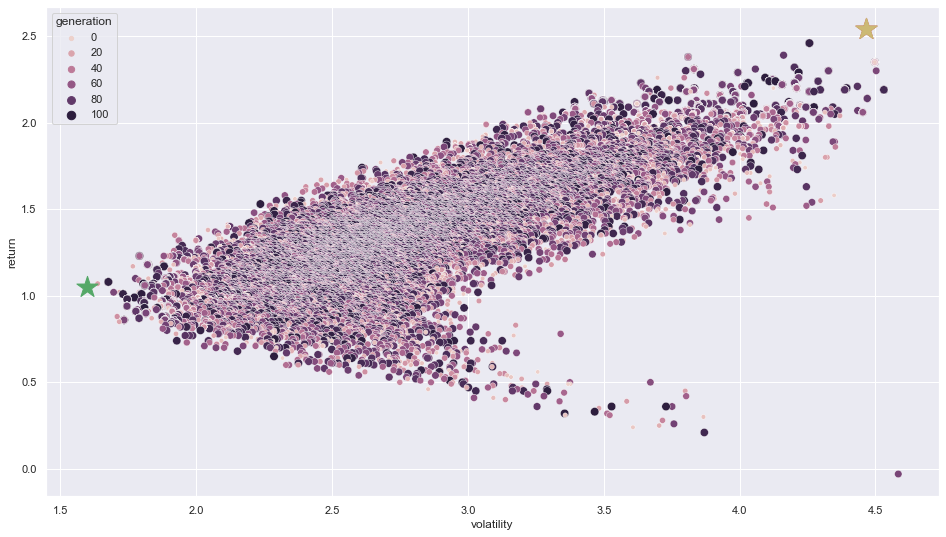

In [628]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = results_df['volatility'],y = results_df['return'], size=results_df['generation'], hue=results_df['generation']) #, style=results_df['name'])
plt.scatter(x = b1['volatility'].iloc[0], y = b1['return'].iloc[0], marker = '*', color = 'r', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b2['volatility'].iloc[0], y = b2['return'].iloc[0], marker = '*', color = 'g', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b3['volatility'].iloc[0], y = b3['return'].iloc[0], marker = '*', color = 'y', s =500, label = 'Max E[Retorno]')

In [629]:
best_portfolios = pd.concat([b1,b2,b3])
best_portfolios

,name,generation,chromosome,return,volatility,sharpe_ratio
9037,tree_3,90,37,2.54,4.465047,0.089585
178,tree_1,1,78,1.05,1.596554,-0.682720
9800,tree_3,98,0,2.54,4.465047,0.089585


In [630]:
w1 = tree2[best_portfolios['generation'].iloc[0]][best_portfolios['chromosome'].iloc[0]].get_weights()
w2 = tree2[best_portfolios['generation'].iloc[1]][best_portfolios['chromosome'].iloc[1]].get_weights()
w3 = tree1[best_portfolios['generation'].iloc[2]][best_portfolios['chromosome'].iloc[2]].get_weights()
d = {'stock_name': stock_names, 'Weights_Portfolio_Maximum_Returns': w1, 'Weights_Portfolio_Volatility_Minimum': w2, 'Weights_Portfolio_sharperatio_optimo': w3}
best_portfolios_weights = pd.DataFrame(data=d)
best_portfolios_weights

,stock_name,Weights_Portfolio_Maximum_Returns,Weights_Portfolio_Volatility_Minimum,Weights_Portfolio_sharperatio_optimo
0,VDC,0.065929,0.103210,1.882218e-02
1,VDE,0.352994,0.076627,8.631093e-09
2,VFH,0.332820,0.346826,1.332631e-01
3,VGT,0.174006,0.103484,8.478262e-01
4,VHT,0.074250,0.369853,8.857702e-05


In [631]:
best_portfolios_weights.to_csv('file1.csv')

In [632]:
a=np.array(best_portfolios_weights["Weights_Portfolio_Maximum_Returns"])

In [633]:
b=np.array(best_portfolios_weights["Weights_Portfolio_Volatility_Minimum"])

In [634]:
c=np.array(best_portfolios_weights["Weights_Portfolio_sharperatio_optimo"])

In [638]:
w1

array([0.06592894, 0.35299412, 0.33282037, 0.17400649, 0.07425008])